<Axes: >

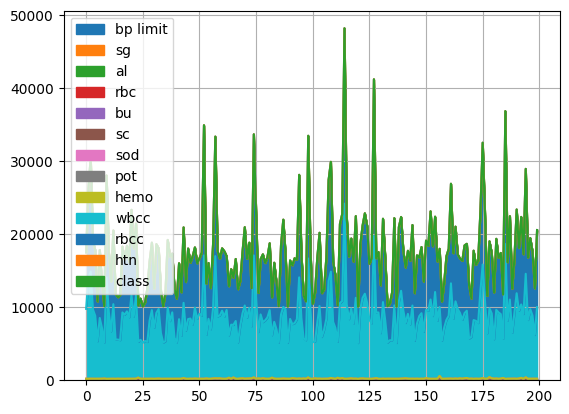

In [1]:
import pandas as pd

sample_stages = pd.read_csv("data/classes.csv")
sample_stages.plot(kind="area", grid=True)

<Axes: >

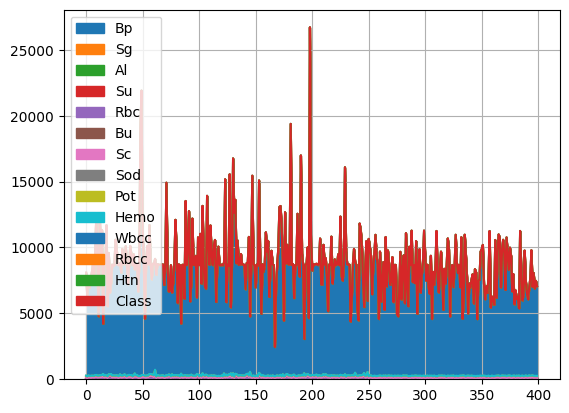

In [2]:
sample_cdk = pd.read_csv("data/cdk.csv")
sample_cdk.plot(kind="area", grid=True)

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
import torch
import joblib

class CDK(Dataset):
    def __init__(self, annotation: str, exclude_columns: list = ["bp", "rbc", 'htn', 'class']) -> None:
        super().__init__()
        self.data = pd.read_csv(annotation)
        self.scaler = MinMaxScaler()
        
        # If no columns are specified for exclusion, default to an empty list
        if exclude_columns is None:
            exclude_columns = []
        
        # Identify the columns to normalize
        self.feature_columns = [col for col in self.data.columns if col.lower() not in exclude_columns]
        
        # Extract features and fit the scaler only to the columns to be normalized
        features = self.data[self.feature_columns].values
        self.scaler.fit(features)
        
        # Normalize the features and store them back in the dataframe
        self.data[self.feature_columns] = self.scaler.transform(features)
        joblib.dump(self.scaler, "model/MinMaxScaler_classfier.pkl")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        label = self.data.loc[index, "Class"]
        features = self.data.iloc[index, :-1]
        try:
            return torch.tensor(features, dtype=torch.float32), torch.tensor(label)
        except:
            print(features, label)
            

    
    
class CDK_STAGES(Dataset):
    def __init__(self, annotation: str, exclude_columns: list = ["bp", "rbc", 'htn', 'class', 'stage']) -> None:
        super().__init__()
        self.data = pd.read_csv(annotation)
        self.scaler = MinMaxScaler()
        
        # If no columns are specified for exclusion, default to an empty list
        if exclude_columns is None:
            exclude_columns = []
        
        # Identify the columns to normalize
        self.feature_columns = [col for col in self.data.columns if col not in exclude_columns]
        
        # Extract features and fit the scaler only to the columns to be normalized
        features = self.data[self.feature_columns].values
        self.scaler.fit(features)
        
        # Normalize the features and store them back in the dataframe
        self.data[self.feature_columns] = self.scaler.transform(features)
        joblib.dump(self.scaler, "model/MinMaxScaler_stage.pkl")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        cdk_stages = {'s1':0,
                      's2':1,
                      's3':2,
                      's4':3,
                      's5':4}
        label = cdk_stages[self.data.loc[index, "stage"]]
        features = self.data.iloc[index, :-1]
        
        try:
            return torch.tensor(features, dtype=torch.float32), torch.tensor(label)
        except:
            print(features, label)
            

In [5]:
from torch.utils.data import random_split, DataLoader

def load_data(data, batch_size: int):
    train_size = int(len(data) * 0.8)
    test_size = len(data) - train_size
    
    train, test = random_split(data, [train_size, test_size])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

cdk_data = CDK("data/cdk.csv")
cdk_stages = CDK_STAGES("data/classes.csv")

cdk_train_loader, cdk_test_loader = load_data(cdk_data, 10)
cdk_stages_train_loader, cdk_stages_test_loader = load_data(cdk_stages, 10)

print("NO. cdk train loaders: ", len(cdk_train_loader))
print("NO. cdk test loaders: ", len(cdk_test_loader))
print("NO. cdk stages train loaders: ", len(cdk_stages_train_loader))
print("NO. cdk stages test loaders: ", len(cdk_stages_test_loader))


NO. cdk train loaders:  32
NO. cdk test loaders:  8
NO. cdk stages train loaders:  16
NO. cdk stages test loaders:  4


In [31]:
sample_feat, sample_label = next(iter(cdk_stages_train_loader))
sample_feat.shape, sample_label.shape

/tmp/ipykernel_70527/2314671083.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(features, dtype=torch.float32), torch.tensor(label)


(torch.Size([10, 13]), torch.Size([10]))

In [32]:
sample_feat_cdk, sample_label_cdk = next(iter(cdk_train_loader))
sample_feat_cdk.shape, sample_label_cdk.shape

/tmp/ipykernel_70527/2314671083.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(features, dtype=torch.float32), torch.tensor(label)


(torch.Size([10, 13]), torch.Size([10]))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
from torch import nn

class CDK_ClASSFIER(nn.Module):
    def __init__(self,feature, num_classes=2) -> None:
        super().__init__()
        self.classfier = nn.Sequential(
            nn.Linear(feature, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.classfier(x))


class CDK_stages(nn.Module):
    def __init__(self,feature, num_classes=2) -> None:
        super().__init__()
        self.classfier = nn.Sequential(
            nn.Linear(feature, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classfier(x)

model = CDK_stages(13, 5).to(device)

In [23]:
from torch import optim

criterion = nn.CrossEntropyLoss()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def save_model(model, path):
    torch.save(model.state_dict(), path)


def train(epoch_num, data, model):
    loss_per = []
    for epoch in range(epoch_num):
        l = 0
        for features, target in data:
            features = features.to(device)
            target = target.to(device)
            
            prediction = model(features)
            loss = criterion(prediction, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            l += (loss.item())
            
        loss_per.append(l/len(data))
        if (epoch+1) % 1000 == 0:
            print(f"Epoch_loss: {epoch + 1}: {l/len(data):.4f}")
            save_model(model, "model/cdk_stages.pth")
        
    plt.plot(np.array(loss_per))
    plt.title("TRAIN LOSS")
    plt.ylabel("loss")
    plt.legend("loss")
    plt.xlabel("epoch")
    plt.savefig("model/train_cdk_classfier.png")
    
    return loss_per

/tmp/ipykernel_70527/2314671083.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(features, dtype=torch.float32), torch.tensor(label)


Epoch_loss: 1000: 0.8292
Epoch_loss: 2000: 0.7115
Epoch_loss: 3000: 0.6131
Epoch_loss: 4000: 0.5318
Epoch_loss: 5000: 0.4658


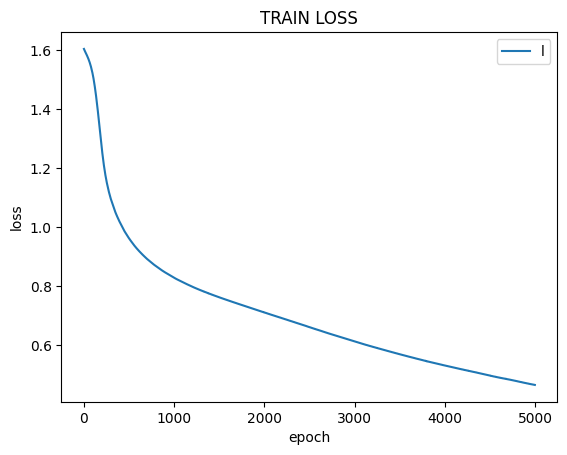

In [25]:
avg_loss = train(5000, cdk_stages_train_loader, model)

In [26]:
def load_model(model, path):
    model.load_state_dict(torch.load(path, map_location=device))
    return model

In [27]:
import torch.nn.functional as F

def test(model, test_loader):
    loaded_model = load_model(model, "model/cdk_stages.pth")
    loaded_model.eval()
    test_loss = []
    correct = 0
    
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = loaded_model(data)
            loss = criterion(output, target)
            test_loss.append(loss.item())
            pred = F.softmax(output).argmax(dim=1, keepdim=True)
            cor = pred.eq(target.view_as(pred)).sum().item()
            correct += cor

    print('\nTest Training: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.array(test_loss).mean(), correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))

In [28]:
test(model, cdk_stages_test_loader)


Test Training: Average loss: 1.3643, Accuracy: 24/40 (60%)



/tmp/ipykernel_70527/2314671083.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(features, dtype=torch.float32), torch.tensor(label)
/tmp/ipykernel_70527/163791609.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(output).argmax(dim=1, keepdim=True)
